In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
#from numpy import random
#np.random.seed(42) # Set seed for reproducibility

from scipy.stats import kstest, probplot, gamma, chi2
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

In [2]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def Q_DM(diff_mean_1, cov_1, n_samples):
    
    # Sampling
    r_tot = np.dot(sqrtm(np.linalg.inv(cov_1)), np.random.multivariate_normal(0*diff_mean_1, cov_1, size=n_samples).T)  # Shape: (d, n_samples)
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)
    return Q

# Claudia: Samplear Q_ii y todos los W_ij con los
#          mismos valores de las samples de las 
#          diferencias de gaussianas.
def Q_tot(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples, L):
    
    # Sampling
    X = np.dot(sqrtm(np.linalg.inv(cov_1)), np.random.multivariate_normal(0*diff_mean_1, cov_1, size=n_samples).T)  # Shape: (d, n_samples)
    Y = np.dot(sqrtm(np.linalg.inv(cov_2)), np.random.multivariate_normal(0*diff_mean_2, cov_2, size=n_samples).T)  # Shape: (d, n_samples)
    Z = np.dot(sqrtm(np.linalg.inv(cov_3)), np.random.multivariate_normal(0*diff_mean_3, cov_3, size=n_samples).T)  # Shape: (d, n_samples)

    r_tot = X + Y + Z

    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)

    return Q / L**2

def beta_statistic(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3):
    """
    Calculate the beta parameter for the given distributions.
    
    Parameters:
    diff_mean_1, diff_mean_2, diff_mean_3: Mean differences for each distribution.
    cov_1, cov_2, cov_3: Covariance matrices for each distribution.
    
    Returns:
    beta: The beta parameter.
    """
    
    beta = np.dot(diff_mean_1, np.linalg.solve(cov_1, diff_mean_1)) + \
           np.dot(diff_mean_2, np.linalg.solve(cov_2, diff_mean_2)) + \
           np.dot(diff_mean_3, np.linalg.solve(cov_3, diff_mean_3))
           
    
    return beta


# Dataset A

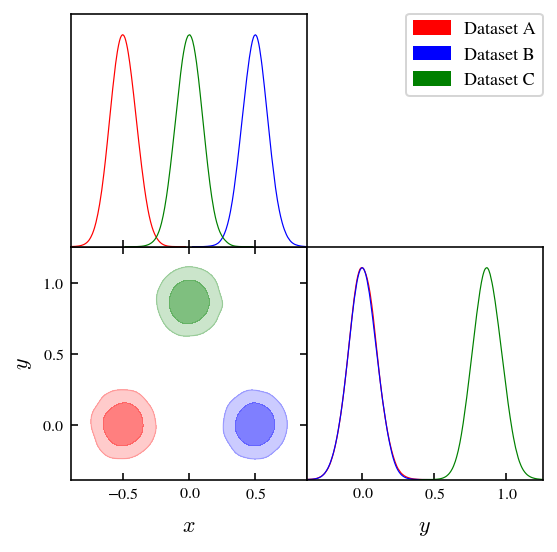

In [3]:
# Fixed constants

# Parameters
d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




# $\tilde{Q} \sim \Gamma(d/2, 2/L)$?

In [4]:
# Fixed constants
# Parameters
d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors


n_samples = int(1e7)  # Number of samples

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

r_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), diff_mean_1)
r_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), diff_mean_2)
r_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), diff_mean_3)

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
beta = beta_statistic(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3)
print(r'$\beta: {}$'.format(beta))
print(r'$Q$: {}'.format(np.linalg.norm(R_CM)**2))

t=np.linspace(0, 1.1*np.linalg.norm(R_CM)**2, 100)
theoretical_dist = gamma.pdf(t,a=d/2, scale=2/L)
sample_dist = Q_tot(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples, L)

$\beta: 150.0$
$Q$: 22.222222222222225


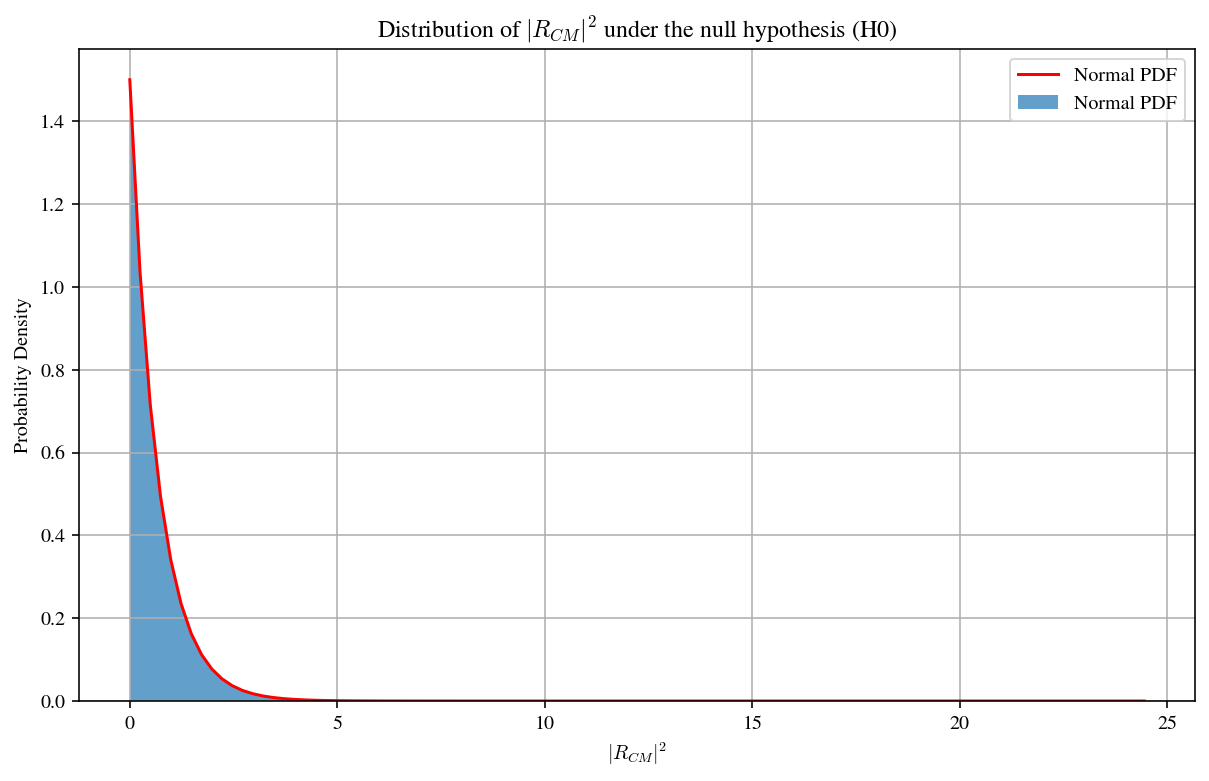

In [5]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sample_dist, label='Normal PDF', density=True, 
         bins=int(np.sqrt(len(sample_dist))), alpha=0.7)
plt.plot(t, theoretical_dist, color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

KS Statistic: 0.0003106999999999971
P-value: 0.7198389865606489
No se rechaza H₀: los datos podrían provenir de una distribución gamma.


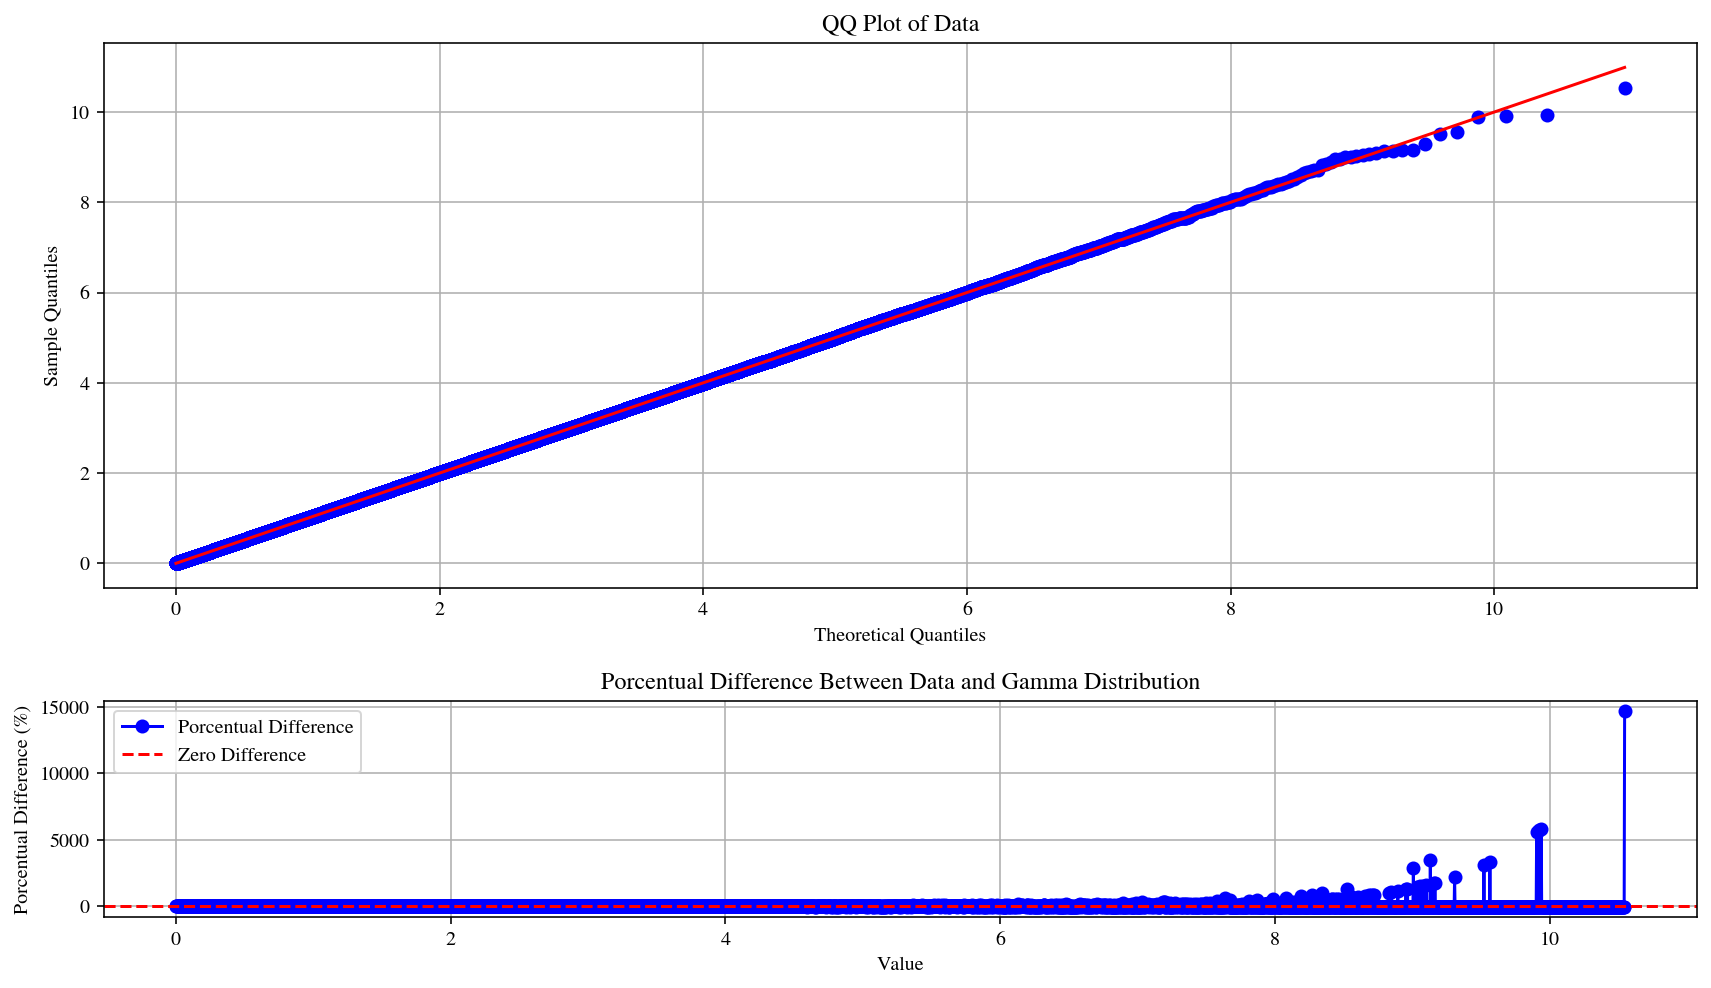

In [6]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = sample_dist
data_th = gamma.rvs(a=d/2, scale=2/L, size=n_samples)

# Realizar el test KS
ks_statistic, p_value = kstest(data, data_th, alternative='two-sided')

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución gamma.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución gamma.")

# Primer gráfico: Diferencia porcentual
t = np.linspace(np.min(data), np.max(data), 100)
norm_pdf = gamma.pdf(t, a=d/2, scale=2/L)
hist, bin_edges = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Calcular la diferencia porcentual
percent_diff = 100 * (hist - np.interp(bin_centers, t, norm_pdf)) / np.interp(bin_centers, t, norm_pdf)

# Crear una figura con dos subplots, uno debajo del otro
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 1)
axs = [fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[2, 0])]
# Primer gráfico: QQ plot
probplot(data, sparams=(d/2, 0, 2/L), dist="gamma", plot=axs[0])
# Personalizar el primer gráfico
axs[0].set_title("QQ Plot of Data")
axs[0].set_xlabel("Theoretical Quantiles")
axs[0].set_ylabel("Sample Quantiles")
axs[0].grid(True)

# Graficar la diferencia porcentual
axs[1].plot(bin_centers, percent_diff, marker='o', linestyle='-', color='blue', label='Porcentual Difference')
axs[1].axhline(0, color='red', linestyle='--', label='Zero Difference')
# Personalizar el segundo gráfico
axs[1].set_title("Porcentual Difference Between Data and Gamma Distribution")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Porcentual Difference (%)")
axs[1].legend()
axs[1].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()

# $Q_{DM} \sim \Gamma(d/2, 2) = \chi^2_{d}$?

In [7]:
# Fixed constants
# Parameters
d = 2 # Dimension of shared parameter space
N = 2 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e7)  # Number of samples

cov_1 = cov_A + cov_B
diff_mean_1 = mean_A - mean_B

r_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), diff_mean_1)

# Example usage:
vectors = np.array(r_1)
R_CM = calculate_R_CM(vectors)

print(r'$Q$: {}'.format(np.linalg.norm(R_CM)**2))

t=np.linspace(0, 1.1*np.linalg.norm(R_CM)**2, 100)
theoretical_dist = gamma.pdf(t,a=d/2, scale=2/L)
sample_dist = Q_DM(diff_mean_1, cov_1, n_samples)


$Q$: 12.500000000000002


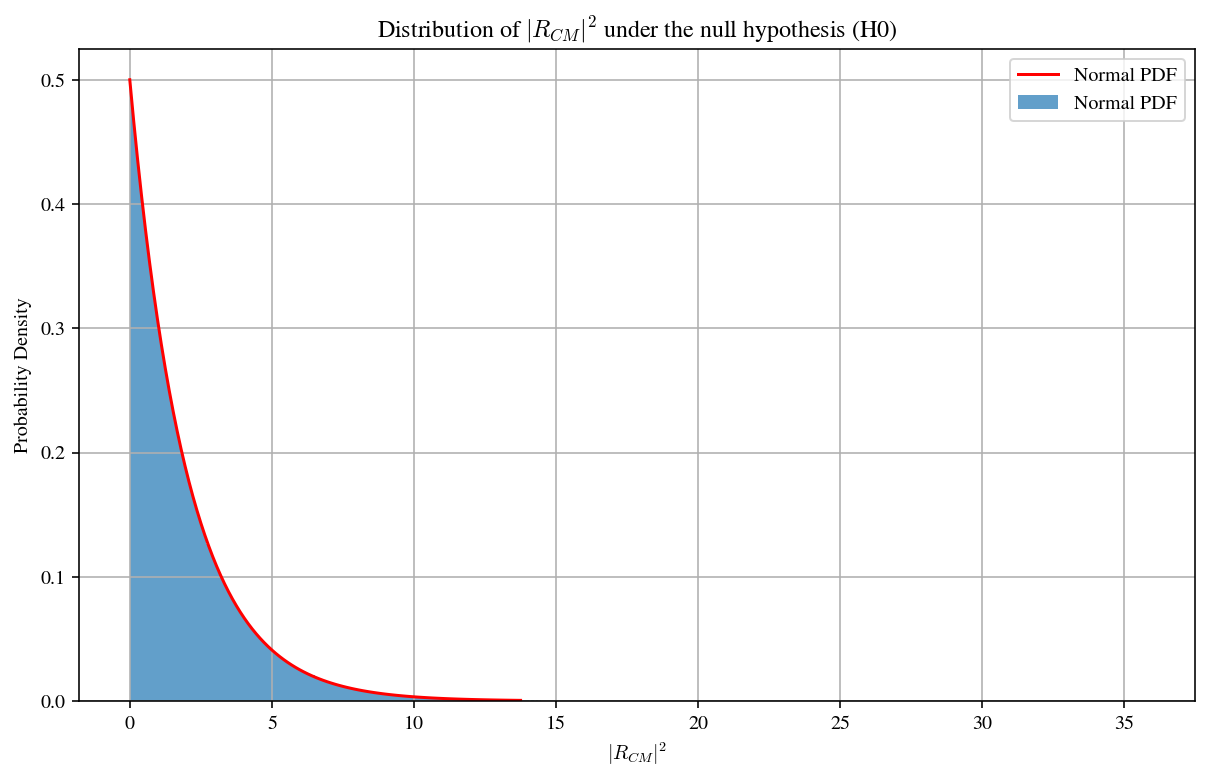

In [8]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sample_dist, label='Normal PDF', density=True, 
         bins=int(np.sqrt(len(sample_dist))), alpha=0.7)
plt.plot(t, theoretical_dist, color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

KS Statistic: 0.00025809999999992783
P-value: 0.8929525854349055
No se rechaza H₀: los datos podrían provenir de una distribución chi2.


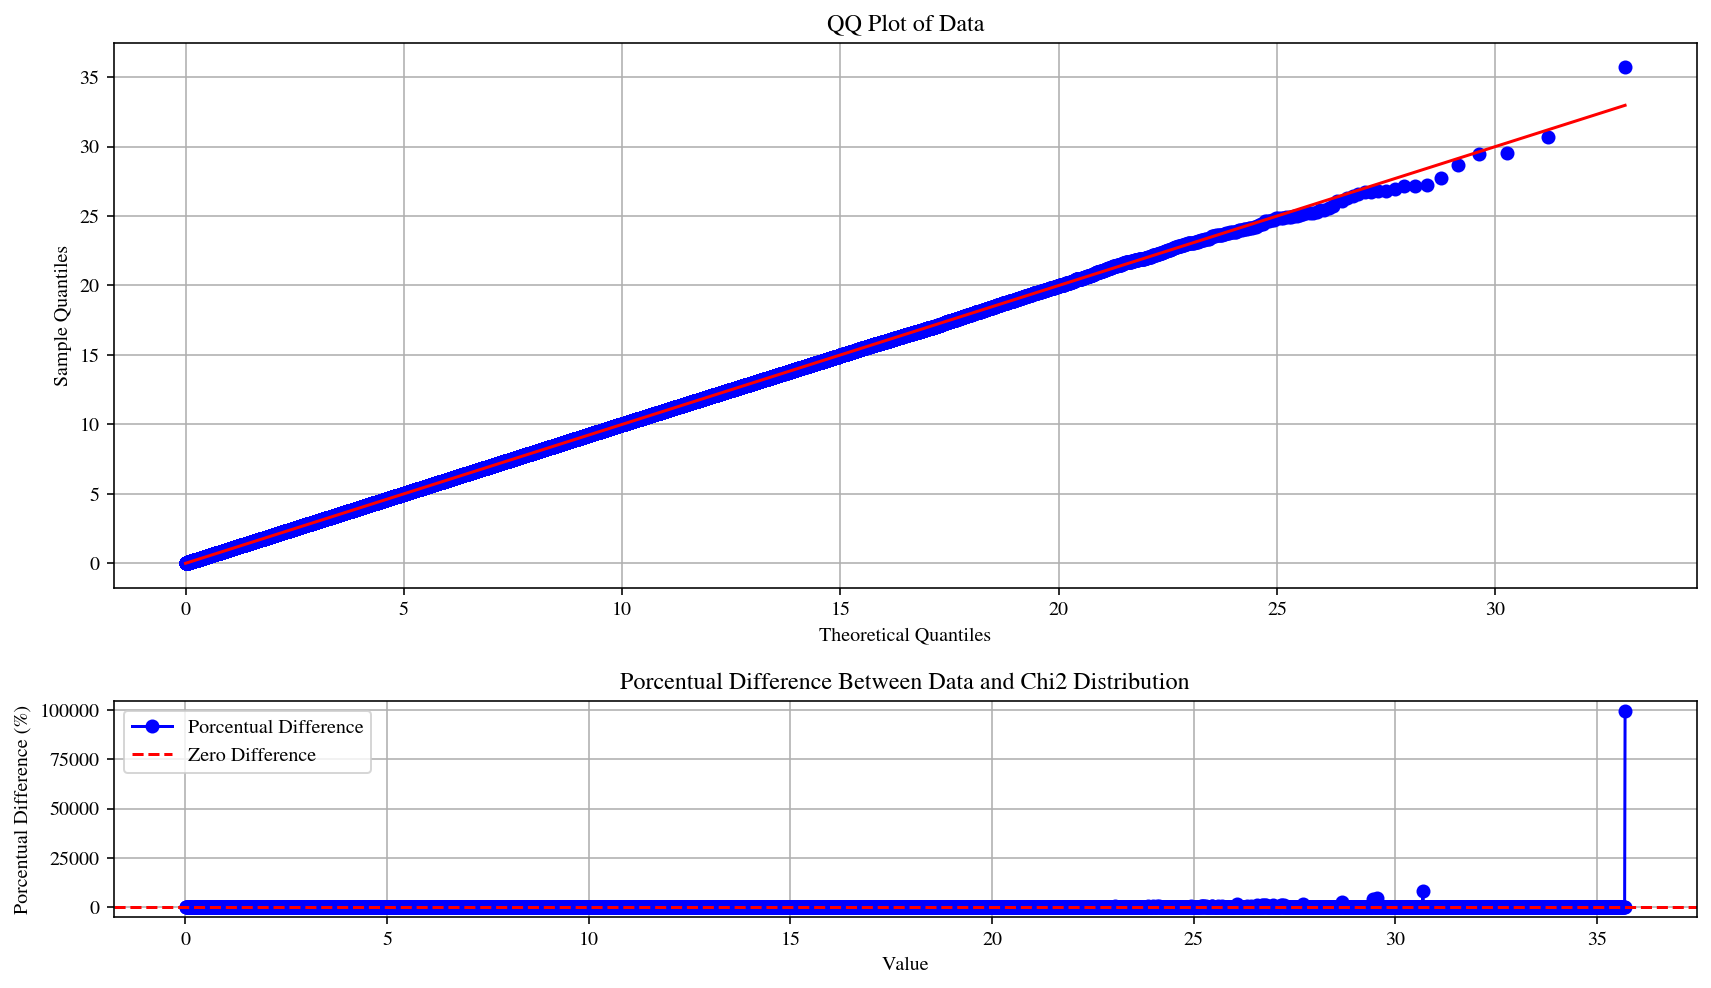

In [9]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = sample_dist
data_th = gamma.rvs(a=d/2, scale=2/L, size=n_samples)

# Realizar el test KS
ks_statistic, p_value = kstest(data, data_th, alternative='two-sided')

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución chi2.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución chi2.")

# Primer gráfico: Diferencia porcentual
t = np.linspace(np.min(data), np.max(data), 100)
norm_pdf = gamma.pdf(t, a=d/2, scale=2/L)
hist, bin_edges = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Calcular la diferencia porcentual
percent_diff = 100 * (hist - np.interp(bin_centers, t, norm_pdf)) / np.interp(bin_centers, t, norm_pdf)

# Crear una figura con dos subplots, uno debajo del otro
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 1)
axs = [fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[2, 0])]
# Primer gráfico: QQ plot
probplot(data, sparams=(d/2, 0, 2/L), dist="gamma", plot=axs[0])
# Personalizar el primer gráfico
axs[0].set_title("QQ Plot of Data")
axs[0].set_xlabel("Theoretical Quantiles")
axs[0].set_ylabel("Sample Quantiles")
axs[0].grid(True)

# Graficar la diferencia porcentual
axs[1].plot(bin_centers, percent_diff, marker='o', linestyle='-', color='blue', label='Porcentual Difference')
axs[1].axhline(0, color='red', linestyle='--', label='Zero Difference')
# Personalizar el segundo gráfico
axs[1].set_title("Porcentual Difference Between Data and Chi2 Distribution")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Porcentual Difference (%)")
axs[1].legend()
axs[1].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()

# $\beta \sim \chi^2_{(N \cdot D)}?$

In [10]:
def beta_sample(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples):
    
    # Sampling
    X = np.dot(sqrtm(np.linalg.inv(cov_1)), np.random.multivariate_normal(0*diff_mean_1, cov_1, size=n_samples).T)  # Shape: (d, n_samples)
    Y = np.dot(sqrtm(np.linalg.inv(cov_2)), np.random.multivariate_normal(0*diff_mean_2, cov_2, size=n_samples).T)  # Shape: (d, n_samples)
    Z = np.dot(sqrtm(np.linalg.inv(cov_3)), np.random.multivariate_normal(0*diff_mean_3, cov_3, size=n_samples).T)  # Shape: (d, n_samples)

    beta = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        beta[i] = np.dot(X[:, i],X[:, i]) + np.dot(Y[:, i],Y[:, i]) + np.dot(Z[:, i],Z[:, i])
        # Shape: (n_samples,)

    return beta

In [11]:
# Fixed constants
# Parameters
d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e7)  # Number of samples

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

# Example usage:
beta = beta_statistic(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3)
print(r'$\beta: {}$'.format(beta))

t=np.linspace(0, 20, 100)
theoretical_dist = chi2.pdf(t,d*N)
sample_dist = beta_sample(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples)

$\beta: 150.0$


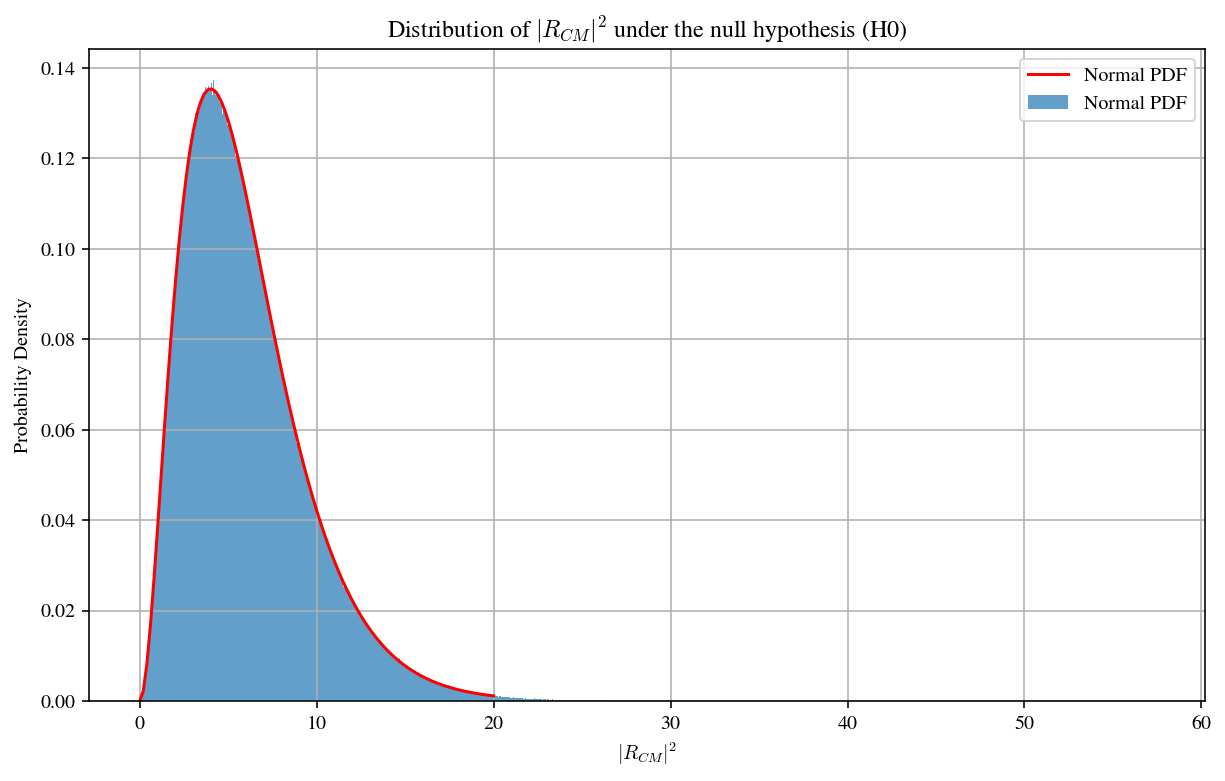

In [12]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sample_dist, label='Normal PDF', density=True, 
         bins=int(np.sqrt(len(sample_dist))), alpha=0.7)
plt.plot(t, theoretical_dist, color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

KS Statistic: 0.0002531000000000061
P-value: 0.9058300474840286
No se rechaza H₀: los datos podrían provenir de una distribución chi2.


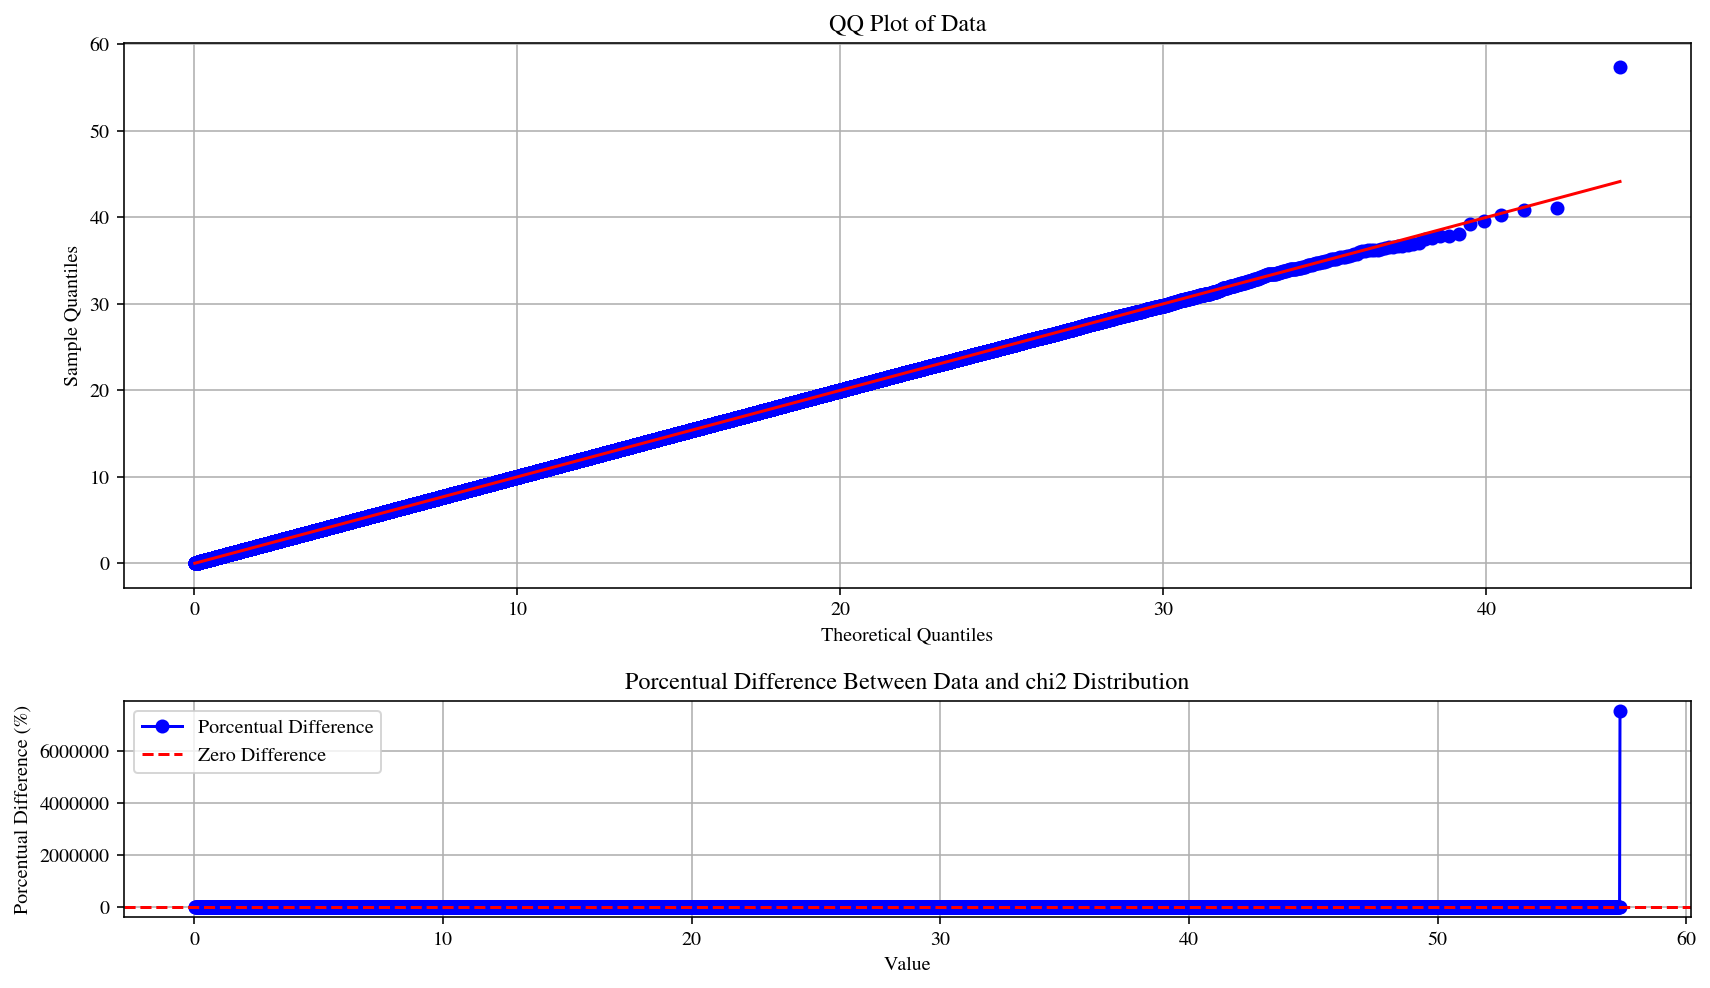

In [13]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = sample_dist
data_th = chi2.rvs(d*N, size=n_samples)

# Realizar el test KS
ks_statistic, p_value = kstest(data, data_th, alternative='two-sided')

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución chi2.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución chi2.")

# Primer gráfico: Diferencia porcentual
t = np.linspace(np.min(data), np.max(data), 100)
norm_pdf = chi2.pdf(t, d*N)
hist, bin_edges = np.histogram(data, bins=int(np.sqrt(len(data))), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Calcular la diferencia porcentual
percent_diff = 100 * (hist - np.interp(bin_centers, t, norm_pdf)) / np.interp(bin_centers, t, norm_pdf)

# Crear una figura con dos subplots, uno debajo del otro
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 1)
axs = [fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[2, 0])]
# Primer gráfico: QQ plot
probplot(data, sparams=(d*N), dist="chi2", plot=axs[0])
# Personalizar el primer gráfico
axs[0].set_title("QQ Plot of Data")
axs[0].set_xlabel("Theoretical Quantiles")
axs[0].set_ylabel("Sample Quantiles")
axs[0].grid(True)

# Graficar la diferencia porcentual
axs[1].plot(bin_centers, percent_diff, marker='o', linestyle='-', color='blue', label='Porcentual Difference')
axs[1].axhline(0, color='red', linestyle='--', label='Zero Difference')
# Personalizar el segundo gráfico
axs[1].set_title("Porcentual Difference Between Data and chi2 Distribution")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Porcentual Difference (%)")
axs[1].legend()
axs[1].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()

# Comparison between $\chi^2_{(N \cdot D)}$ and $\Gamma(D/2, 2/L)$

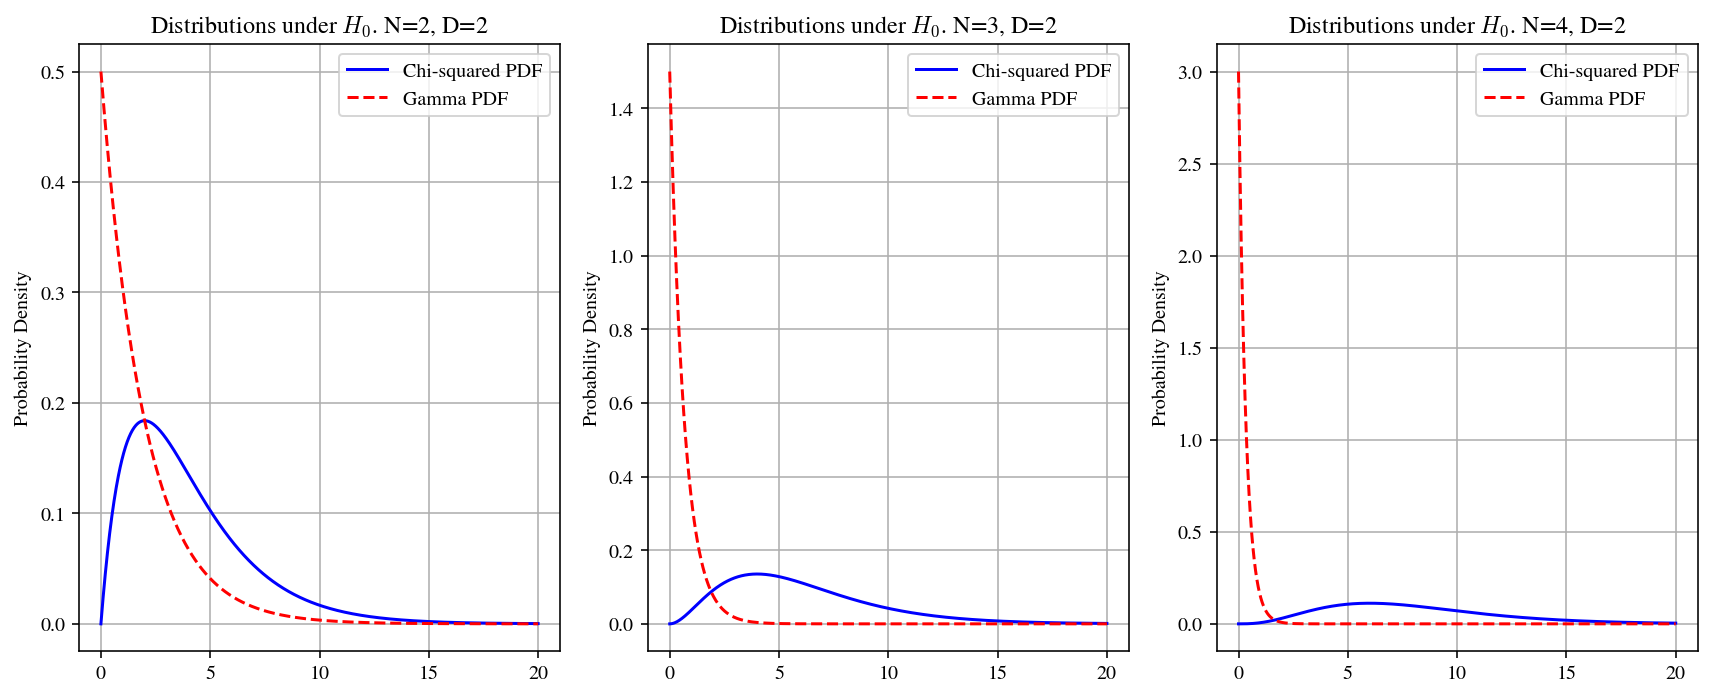

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

d = 2 # Dimension of shared parameter space
N = 2 # Num of datasets
L = N*(N-1)/2
t = np.linspace(0,20,1000)
chi2_th = chi2.pdf(t,d*N)
gamma_th = gamma.pdf(t,a=d/2, scale=2/L)
axs[0].plot(t, chi2_th, color='blue', label='Chi-squared PDF')
axs[0].set_title(r'Distributions under $H_0$. N={}, D={}'.format(int(N),d))
axs[0].set_ylabel('Probability Density')
axs[0].grid(True)
axs[0].legend()
axs[0].plot(t, gamma_th, linestyle='dashed', color='red', label='Gamma PDF')
axs[0].grid(True)
axs[0].legend()

d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2
t = np.linspace(0,20,1000)
chi2_th = chi2.pdf(t,d*N)
gamma_th = gamma.pdf(t, a=d/2, scale=2/L)
axs[1].plot(t, chi2_th, color='blue', label='Chi-squared PDF')
axs[1].set_title(r'Distributions under $H_0$. N={}, D={}'.format(int(N),d))
axs[1].set_ylabel('Probability Density')
axs[1].grid(True)
axs[1].legend()
axs[1].plot(t, gamma_th, linestyle='dashed',color='red', label='Gamma PDF')
axs[1].grid(True)
axs[1].legend()

d = 2 # Dimension of shared parameter space
N = 4 # Num of datasets
L = N*(N-1)/2
t = np.linspace(0,20,1000)
chi2_th = chi2.pdf(t,d*N)
gamma_th = gamma.pdf(t, a=d/2, scale=2/L)
axs[2].plot(t, chi2_th, color='blue', label='Chi-squared PDF')
axs[2].set_title(r'Distributions under $H_0$. N={}, D={}'.format(int(N),d))
axs[2].set_ylabel('Probability Density')
axs[2].grid(True)
axs[2].legend()
axs[2].plot(t, gamma_th, linestyle='dashed',color='red', label='Gamma PDF')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

(Ver el segundo caso) 
Tiene mayor $N_\sigma$ el que tiene una integral hacia infinito mas pequeña. Como $\beta*$ es mayor que $Q*$

- Si la tension es grande, las distribuciones se parecen mas y el que tiene un valor * mas grande tendrá mayor $N_\sigma$.

- Si la tension es pequeña (ver por ejemplo el punto donde interseccionan las curvas en el segundo grafico), el area bajo la curva a la derecha de la curva $\Gamma$ (Q-roja) es menor que la de $\chi^2$ ($\beta$-azul). Aun si beta comienza a integrar un poco mas a la derecha, el area bajo la curva es mayor en este caso, por lo que la tension para $\beta$ es menor a $Q$ en el caso de poca tension.